In [1]:
import json
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sb
import matplotlib.pyplot as plt

np.random.seed(503)

In [2]:
# General parameters for the script
target_name = 'RegisteredInTargetPeriod'  # Target variable
features = [
    'DaysSinceLastRegistration', 'DaysSinceFirstRegistration',
    'PastRegistrations', 'LastDonationLocation_Center',
    'LastDonationType_Platelets', 'CenterRegistrationProportion', 'DonationsPerDay',
    'PlateletRegistrationProportion'
]

# Decide whether we're loading a subset or the full set
# dataset_size = 'partial'
dataset_size = 'full'

if dataset_size == 'full':
    file_names = {
        'X': 'X_test_full.csv',
        'y': 'y_test_full.csv',
        'model': '../../models/classifier_full.pkl'
    }
elif dataset_size == 'partial':
    file_names = {
        'X': 'X_test.csv',
        'y': 'y_test.csv',
        'model': '../../models/classifier.pkl'
    }

In [3]:
# Load data
with open('../../data/processed/dtypes.json') as in_file:
    non_date_dtypes = json.load(in_file)

with open('../../data/processed/date_types.json') as in_file:
    date_dtypes = json.load(in_file)

date_cols = list(date_dtypes)

# Read data, specifically parsing date columns as dates and only picking the features + target
X_test = pd.read_csv('../../data/processed/{0}'.format(file_names['X']), dtype=non_date_dtypes, index_col=0)
y_test = pd.read_csv('../../data/processed/{0}'.format(file_names['y']), index_col=0)

In [4]:
# Load model
clf = joblib.load(file_names['model'])

In [5]:
# Score model
y_pred = clf.predict(X_test)
precision_score(y_test, y_pred)

0.6568227624121192

In [6]:
pd.Series(y_pred).value_counts()

0    1986759
1     105683
dtype: int64

In [7]:
y_pred_prob = clf.predict_proba(X_test)

In [8]:
clf.score(X_test, y_test)

0.8600840548985348

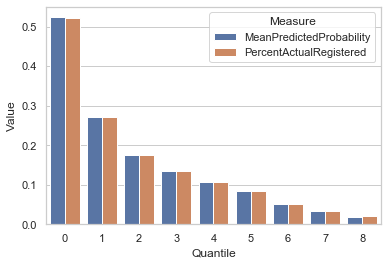

In [15]:
# Do quantile plot for downsampled data
pred_probs = y_pred_prob[:, 1]  # Prediction of positive target

probs_vs_actual = pd.DataFrame(
    np.stack((y_test.squeeze(), pred_probs), axis=1),
    columns=[target_name, 'PredictedProbabilityOfRegistration']
)

# Sort in place
probs_vs_actual.sort_values(by='PredictedProbabilityOfRegistration', ascending=False, inplace=True)

# Assign quantiles
probs_vs_actual['Quantile'] = pd.qcut(-probs_vs_actual['PredictedProbabilityOfRegistration'], 9, labels=False)

# Calculate stats for each quantile: total actual registrations, total donors, and mean predicted probability
quantile_stats = probs_vs_actual.groupby('Quantile').agg({target_name: ['sum', 'count'], 'PredictedProbabilityOfRegistration': 'mean'})

# Rename columns
quantile_stats.columns = ['ActualRegistered', 'TotalInQuantile', 'MeanPredictedProbability']

# Just get the two variables we care about
quantile_stats['PercentActualRegistered'] = quantile_stats['ActualRegistered'] / quantile_stats['TotalInQuantile']
quantile_stats.reset_index(inplace=True)
quantile_stats.drop(['ActualRegistered', 'TotalInQuantile'], axis=1, inplace=True)

# Melt so we can plot mean predicted probability and actual % registered together
melted_quantile_stats = pd.melt(quantile_stats, id_vars='Quantile', var_name='Measure', value_name='Value')

sb.set(style='whitegrid')
ax = sb.barplot(x='Quantile', y='Value', hue='Measure', data=melted_quantile_stats)